Install segments.ai

In [ ]:
!pip install segments-ai

  Created wheel for segments-ai: filename=segments_ai-0.54-py3-none-any.whl size=14682 sha256=b9c0ad015234d65849d962ce31eb3ec4005ea52f7f8889d5357a60c8baed8cb0
  Stored in directory: /root/.cache/pip/wheels/6f/b2/ab/66f70f1fe800500afc6d43870988dd7a2feb4e3ce325459ede
Successfully built segments-ai


Packages

In [ ]:
from segments import SegmentsClient, SegmentsDataset
from segments.utils import export_dataset, get_semantic_bitmap
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import os
import pytz
import datetime
import requests
import plotly.graph_objs as go

Downloading released and labeled data

In [ ]:
def log(msg='...', path=''):
    tz_ZH = pytz.timezone('Europe/Zurich')
    now = datetime.datetime.now(tz_ZH)
    now_string = now.strftime("%H:%M:%S")
    print('log: {} {:<20s} {:>45}'.format(now_string, msg, path))

In [ ]:
def download_file_from_google_drive(id, destination):
    # source https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url/60132855#60132855
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
             for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

In [ ]:
parent_dir='data'
if not os.path.exists(parent_dir):
    log('creating directory:',parent_dir)
    os.makedirs(parent_dir)

directories=['01_downloads']
for dir in directories:
    path = os.path.join(parent_dir, dir)
    if not os.path.exists(path):
        os.makedirs(path)
        log('creating directory:',path)

log: 16:22:17 creating directory:                                           data
log: 16:22:17 creating directory:                              data/01_downloads


In [ ]:
# Downloading released and labeled data from Google Drive
downloading = {"solar_panels_eda": "1fU5BWPNrTr8I2VRheZ1G8a9xNQJqMka5"} # file name : file id
download_dir = os.path.join(parent_dir, directories[0]) # path to directory "01_downloads"

for file_name, file_id in downloading.items():
  path=os.path.join(download_dir, file_name+".json")
  log("downloading:", path)
  download_file_from_google_drive(file_id, path) # download and save

log: 16:38:05 downloading:          data/01_downloads/solar_panels-v0.5_eda.json


In [ ]:
# Initialize a SegmentsDataset from the release file
client = SegmentsClient(api_key='0e37cf5cca4fe748d5277b9893d3a95a08f2bd31')
release = "/content/solar_panels_eda.json" # eventually adjusting path
dataset = SegmentsDataset(release, labelset='ground-truth', filter_by=['labeled'])

Initialized successfully.
Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 2599/2599 [05:42<00:00,  7.59it/s]

Initialized dataset with 2599 images.


Encoding mask to RLE

In [ ]:
def mask_to_rle(mask):
    """Encodes a mask in Run Length Encoding (RLE).
    Returns a string of space-separated values.
    """
    assert mask.ndim == 2, "Mask must be of shape [Height, Width]"
    # Flatten it row wise
    m = mask.flatten()
    # Compute gradient. Equals 1 or -1 at transition points
    g = np.diff(np.concatenate([[0], m, [0]]), n=1)
    # 1-based indicies of transition points (where gradient != 0)
    rle = np.where(g != 0)[0].reshape([-1, 2]) + 1
    # Convert second index in each pair to lenth
    rle[:, 1] = rle[:, 1] - rle[:, 0]
    return " ".join(map(str, rle.flatten()))

Creating dataframe with ImageId, EncodedPixels, ClassId, NumberObj

In [ ]:
df = []
for sample in dataset:
  df.append(
      {
          'ImageId': sample["name"],
          'EncodedPixels': mask_to_rle(get_semantic_bitmap(sample["segmentation_bitmap"], sample["annotations"])),
          'ClassId': sample["annotations"],
          'NumberObj': len(sample["annotations"])
      }
  )
df = pd.DataFrame(df)

**Exploratory data analysis**

In [ ]:
print("Total number of images: " + str(df.shape[0]))
print("Images with solar equipments: " + str(sum(df["NumberObj"]>0)))
print("Minimum number of solar equipments: " + str(min(filter(lambda i: i > 0, df["NumberObj"]))))
print("Maximum number of solar equipments: " + str(max(df["NumberObj"])))

Total number of images: 2599
Images with solar equipments: 2180
Minimum number of solar equipments: 1
Maximum number of solar equipments: 78


Proportion of Images with Solar Plants

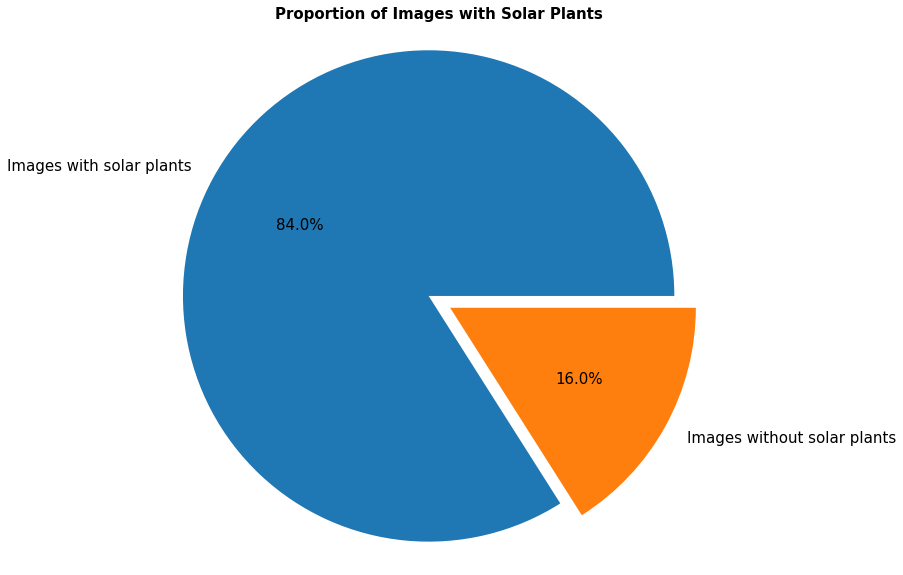

In [ ]:
solar = sum(df["NumberObj"] > 0) # number of images with solar plants
nsolar = sum(df["NumberObj"] == 0) # number of images without solar plants
total = solar + nsolar
solar_p = round(solar/(total)*100)
nsolar_p = round(nsolar/(total)*100)

labels = "Images with solar plants", "Images without solar plants"
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(15, 10))
ax1.pie([solar_p, nsolar_p], explode=explode, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 15})
ax1.axis('equal')
plt.title('Proportion of Images with Solar Plants', fontweight = 'bold', fontsize = 15)
plt.show()

Proportion of Images per Flight Year

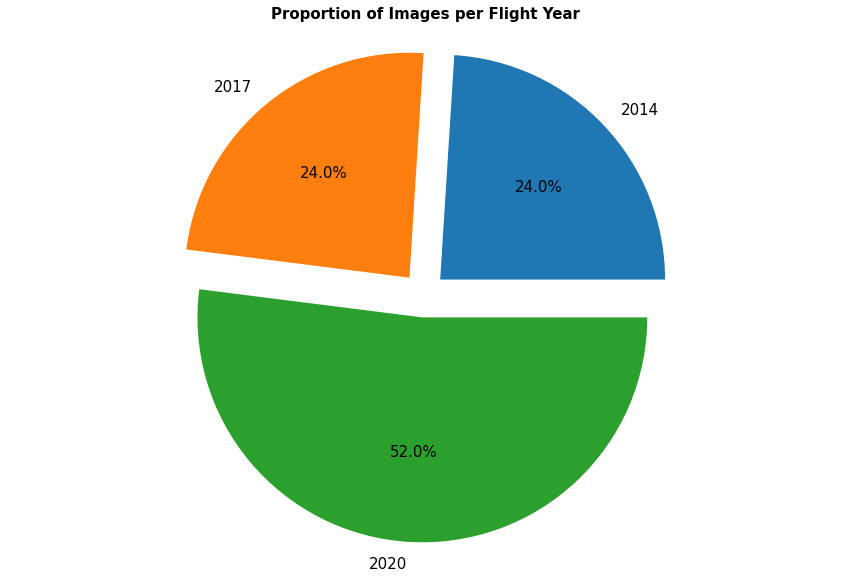

In [ ]:
flighty = df.ImageId.str[0:4] # adding flight year
first = sum(flighty == "2014") # number of images in 2014
second = sum(flighty == "2017") # number of images in 2017
third = sum(flighty == "2020") # number of images in 2020
total = first + second + third
first_p = round(first/(total)*100)
second_p = round(second/(total)*100)
third_p = round(third/(total)*100)

labels = "2014", "2017", "2020"
explode = (0.1, 0.1, 0.1)
fig1, ax1 = plt.subplots(figsize=(15, 10))
ax1.pie([first_p, second_p, third_p], explode=explode, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 15})
ax1.axis('equal')
plt.title('Proportion of Images per Flight Year', fontweight = 'bold', fontsize = 15)
plt.show()

Number of Solar Plants per Image

Text(0.5, 1.0, 'Bar Chart with Number of Solar Plants')

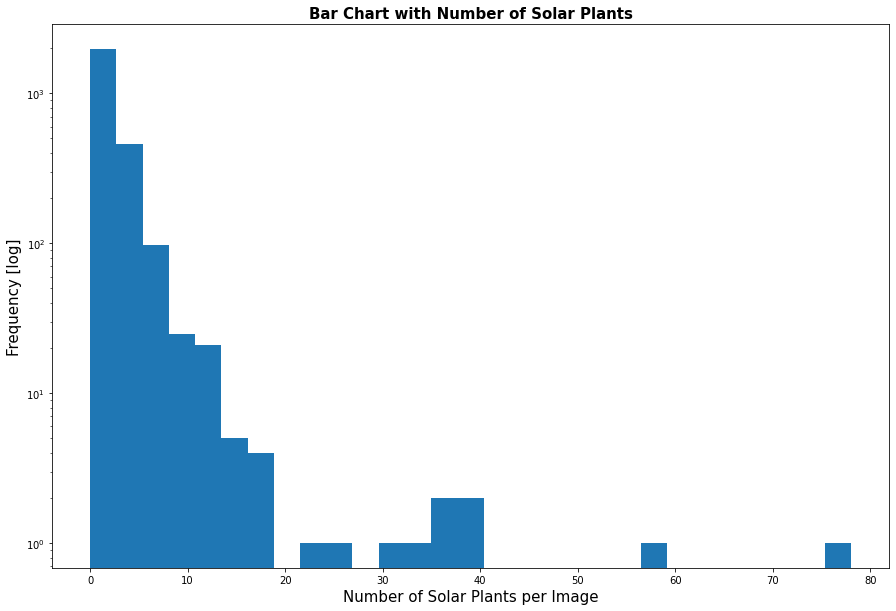

In [ ]:
df["NumberObj"].plot(kind="hist", title ="Histogram of Number of Solar Plants per Image", figsize=(15, 10), bins=len(df["NumberObj"].unique()))
plt.xlabel('Number of Solar Plants per Image', fontsize = 15)
plt.ylabel('Frequency [log]', fontsize = 15)
plt.yscale('log')
plt.title('Bar Chart with Number of Solar Plants', fontweight = 'bold', fontsize = 15)

Example image and mask

In [ ]:
img = dataset[38]["image"]
mask = get_semantic_bitmap(dataset[38]['segmentation_bitmap'], dataset[38]['annotations'])

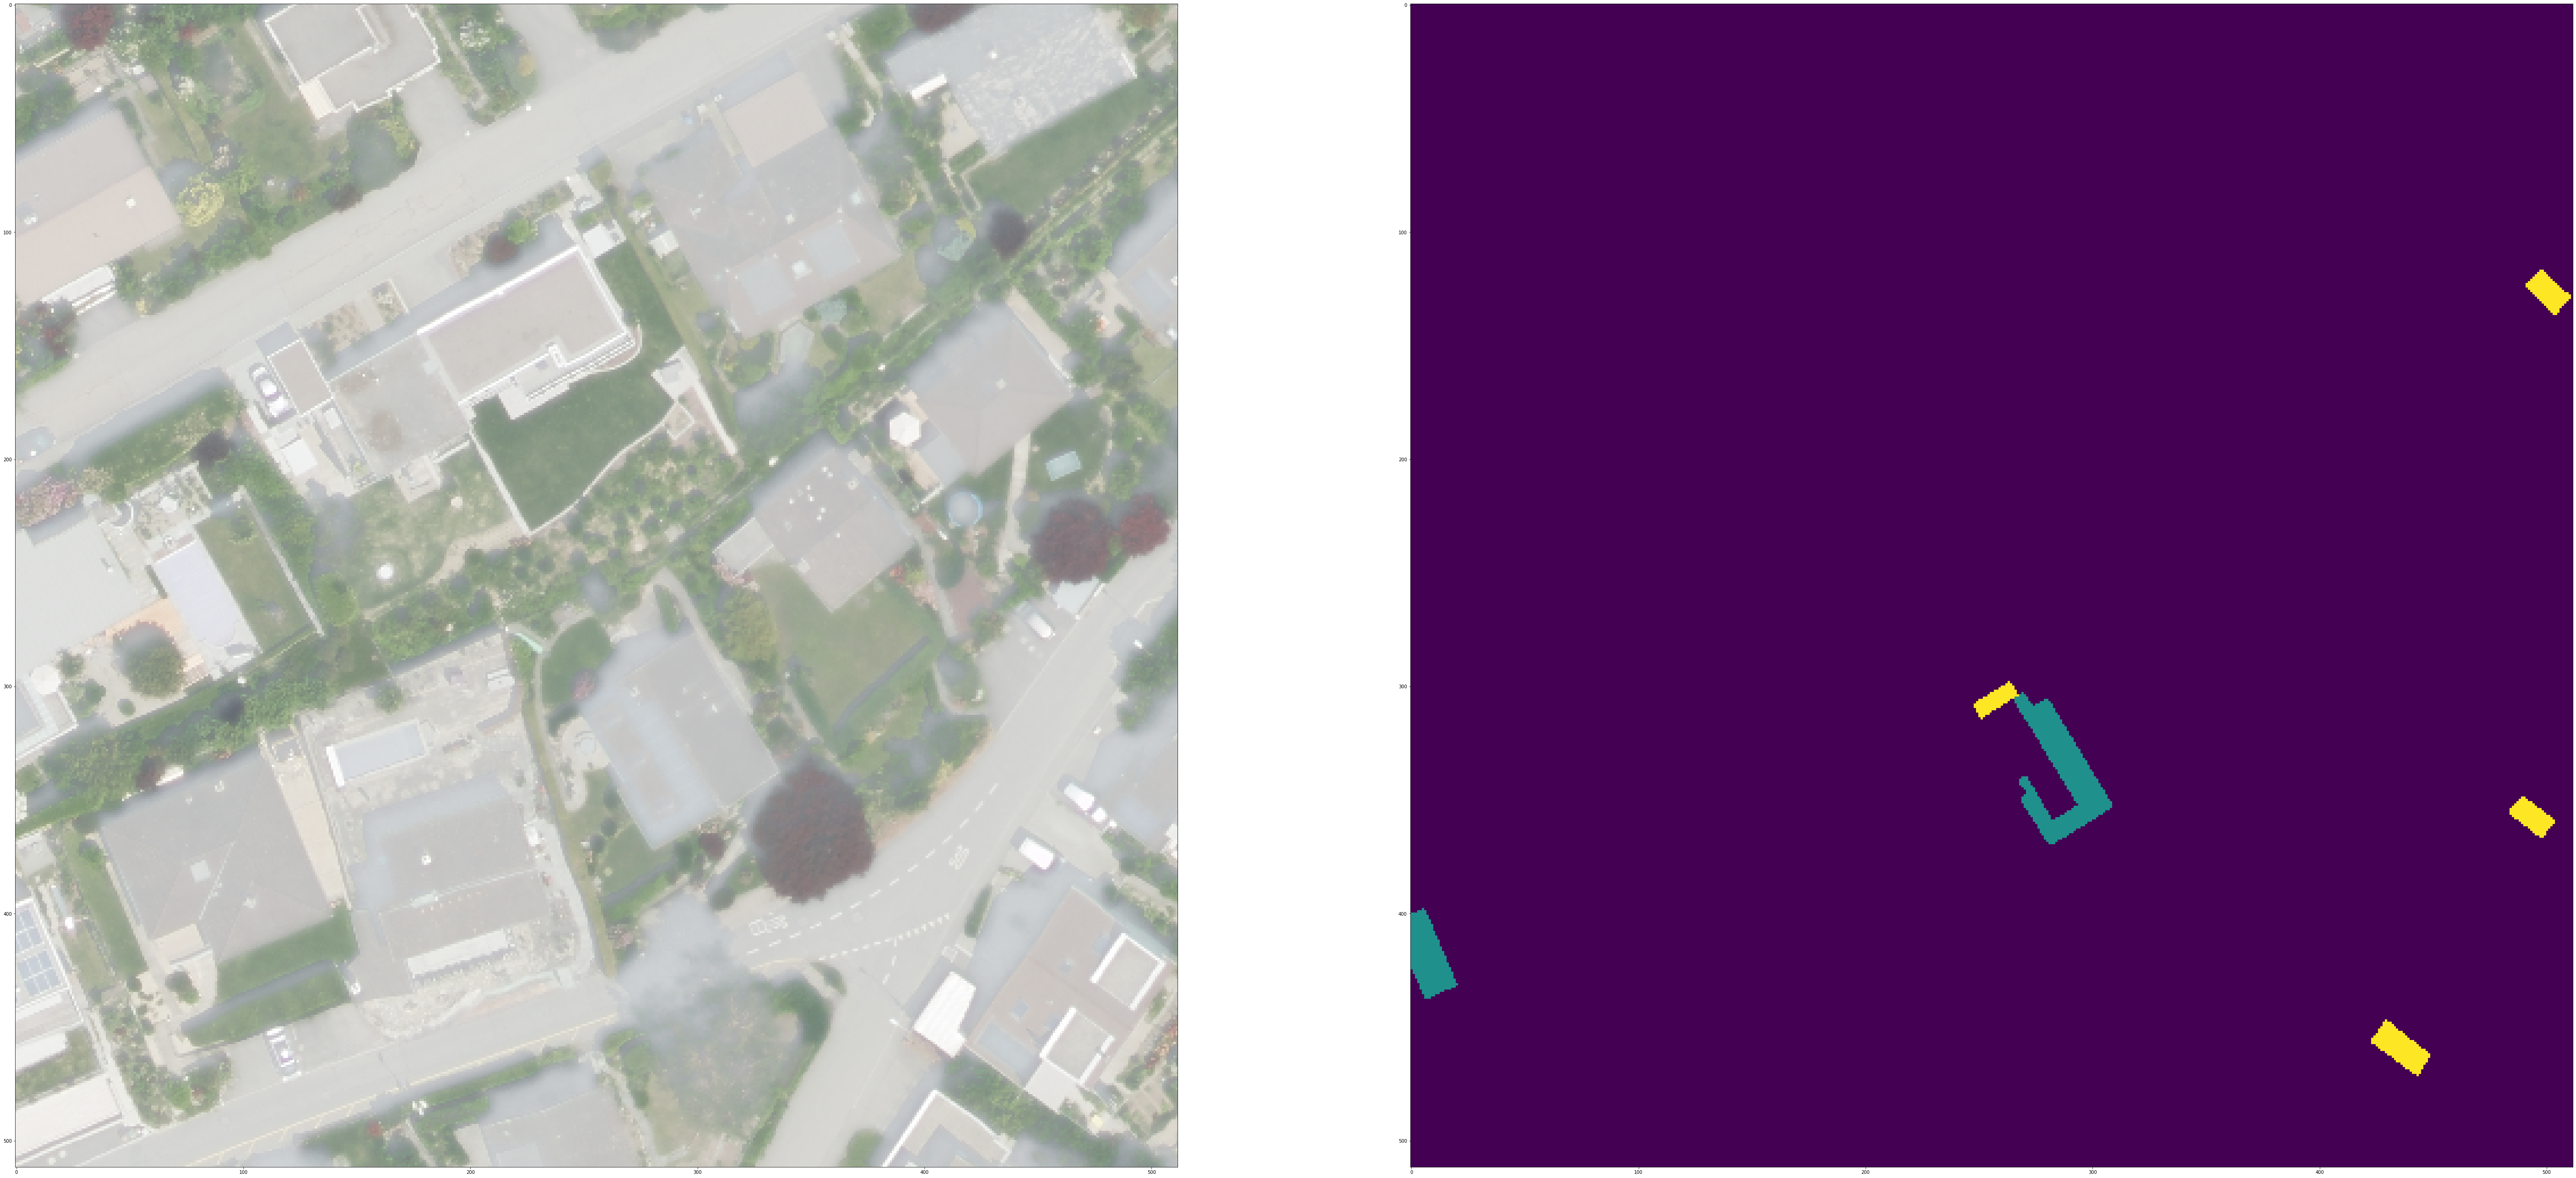

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(100)
f.set_figwidth(100)
ax1.imshow(img)
ax2.imshow(mask)

Extracting category_id's from ClassId

In [ ]:
df["ClassId"] = df["ClassId"].map(lambda x:[i["category_id"] for i in x]) # extracting category_id's from ClassId
df["ClassId"] = df["ClassId"].apply(lambda x: sorted(x))  # sorting ascending, within ClassId-lists

New column "DistinctObjTypes": contains NULL, pv, solar or both

In [ ]:
df['DistinctObjTypes'] = df['ClassId'].apply(lambda x: len(set(x))) # contains NULL, pv, solar or both
df

,ImageId,EncodedPixels,ClassId,NumberObj,DistinctObjTypes
0,2014_2641743.0196_1201147.9929_FID_104_20cm.png,,[],0,0
1,2017_2651675.8196_1224802.3929_FID_3145_20cm.png,11777 1 12289 4 12801 6 13313 8 13825 11 14337...,[0],1,1
2,2017_2651983.0196_1214459.9929_FID_1452_20cm.png,12289 6 12801 15 13313 23 13825 31 14337 40 14...,[0],1,1
3,2020_2635087.0196_1231048.7930_FID_5394_20cm.png,181222 1 181732 4 182241 7 182750 10 183258 15...,[0],1,1
4,2017_2651983.0196_1225314.3929_FID_3242_20cm.png,29277 2 29788 4 30300 6 30811 8 31323 10 31834...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]",13,2
...,...,...,...,...,...
2594,2020_2639695.0196_1235656.7930_FID_5839_20cm.png,150128 1 150639 4 151150 6 151661 8 152172 10 ...,"[0, 0, 1]",3,2
2595,2014_2641231.0196_1227259.9929_FID_2246_20cm.png,192 16 224 8 704 14 725 1 736 10 1217 11 1236 ...,"[0, 0, 0, 0, 0, 1]",6,2
2596,2020_2653109.4196_1220091.9929_FID_3227_20cm.png,60000 3 60512 4 61023 6 61535 8 62047 9 62557 ...,"[0, 0, 0, 1]",4,2
2597,2017_2653519.0196_1219989.5930_FID_2366_20cm.png,32 10 50 16 545 8 563 16 1059 4 1076 16 1572 2...,"[0, 1, 1]",3,2


Counting possible combinations of labels

In [ ]:
permutations = pd.DataFrame(data=df.ClassId.astype(str).value_counts().head(5))

# frequency per combination
permutations['Frequency'] = round(permutations['ClassId'] / permutations['ClassId'].sum() * 100, 2)
permutations['Frequency'] = permutations['Frequency'].astype(str) + '%'

# interactive graphs
fig = go.Figure(

    data=go.Bar(
        orientation='h',
        x=permutations.ClassId,
        y=permutations.index,
        hovertext=permutations.Frequency,
        text=permutations.ClassId,
        textposition='auto'),

    layout=go.Layout(
        title='Counting of Distinct Solar Panels Combinations in Images - Top 5',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=500
    )
)

# display
fig.show()